# Step 5: Second Model - KMeans Clustering

This notebook implements KMeans clustering with PCA dimensionality reduction as our second model. Unlike KNN (supervised), KMeans is unsupervised as it finds natural groupings in the data without using the actual Nutri-Score labels during training.

## Why KMeans?

KMeans is fundamentally different from KNN - it's unsupervised (no labels) vs supervised learning. This lets us test whether products naturally group by nutrition patterns without being told the Nutri-Score grades.

We chose k=5 to align with the 5 Nutri-Score grades (A-E) and see if unsupervised clustering discovers the same categories.

## Setup

In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [69]:
# paths for local execution
data_dir = "../data"
results_dir = "../plots"

# uncomment below if using google colab
# data_dir = "/content/drive/MyDrive/DSE220 Group Project/data"
# results_dir = "/content/drive/MyDrive/DSE220 Group Project/results"

os.makedirs(results_dir, exist_ok=True)
print(f"Data: {data_dir}")
print(f"Results: {results_dir}")

Data: ../data
Results: ../plots


## Load Preprocessed Data

Loading preprocessed data from Notebook 3. Since KMeans is unsupervised (doesn't use labels during training), we can combine all splits. We'll keep the labels for evaluation purposes to see if clusters align with actual grades.

In [70]:
# load the three splits from notebook 3
train_df = pd.read_csv(f"{data_dir}/train_processed.csv")
val_df = pd.read_csv(f"{data_dir}/val_processed.csv")
test_df = pd.read_csv(f"{data_dir}/test_processed.csv")

print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")
print(f"Test: {test_df.shape}")

Train: (387085, 38)
Val: (52411, 38)
Test: (52411, 38)


In [71]:
# combine all data for unsupervised learning
full_df = pd.concat([train_df, val_df, test_df], axis=0).reset_index(drop=True)
print(f"Combined: {full_df.shape}")

# separate features from target
target_col = "nutriscore_grade_encoded"
feature_cols = [c for c in full_df.columns if c != target_col]

X_full = full_df[feature_cols].to_numpy()
y_full = full_df[target_col].astype(int)

print(f"Features: {len(feature_cols)}")
print(f"Samples: {X_full.shape[0]:,}")

Combined: (491907, 38)
Features: 37
Samples: 491,907


## PCA: Dimensionality Reduction

Before running KMeans, we apply PCA to reduce dimensions and understand feature redundancy (37 Feautures). It also improves KMeans performance by reducing dimensionality and removing correlated features.

PCA finds new axes (principal components) that capture maximum variance:
- PC1 = direction of highest variance
- PC2 = second-highest variance (orthogonal to PC1)
- Etc

In [72]:
# fit pca with up to 30 components to analyze variance
n_components_explore = min(30, X_full.shape[1])
pca_full = PCA(n_components=n_components_explore, random_state=42)
X_pca_full = pca_full.fit_transform(X_full)

explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var_ratio)

print("Variance explained (first 10):")
for i in range(min(10, len(explained_var_ratio))):
    print(f"  PC{i+1}: {explained_var_ratio[i]:.4f} (cumulative: {cumulative_var[i]:.4f})")

Variance explained (first 10):
  PC1: 0.7947 (cumulative: 0.7947)
  PC2: 0.2045 (cumulative: 0.9991)
  PC3: 0.0009 (cumulative: 1.0000)
  PC4: 0.0000 (cumulative: 1.0000)
  PC5: 0.0000 (cumulative: 1.0000)
  PC6: 0.0000 (cumulative: 1.0000)
  PC7: 0.0000 (cumulative: 1.0000)
  PC8: 0.0000 (cumulative: 1.0000)
  PC9: 0.0000 (cumulative: 1.0000)
  PC10: 0.0000 (cumulative: 1.0000)


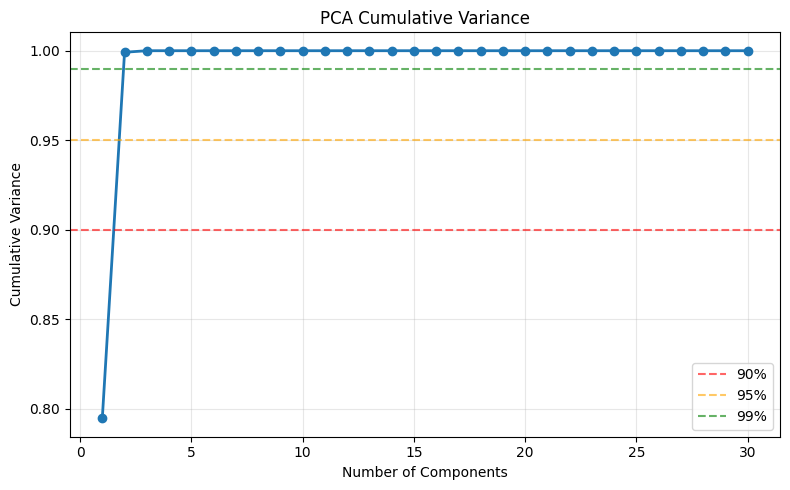

In [73]:
# plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linewidth=2)
plt.axhline(0.90, linestyle='--', color='red', alpha=0.6, label='90%')
plt.axhline(0.95, linestyle='--', color='orange', alpha=0.6, label='95%')
plt.axhline(0.99, linestyle='--', color='green', alpha=0.6, label='99%')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.title("PCA Cumulative Variance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{results_dir}/pca_cumulative_variance.png", dpi=300, bbox_inches="tight")
plt.show()

In [74]:
# apply pca with 2 components
n_components = 2
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_full)

print(f"PCA with {n_components} components")
print(f"Variance explained: {pca.explained_variance_ratio_}")
print(f"Total variance: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Shape: {X_full.shape} -> {X_pca.shape}")

PCA with 2 components
Variance explained: [0.79466157 0.2044749 ]
Total variance: 0.9991
Shape: (491907, 37) -> (491907, 2)


### PCA Results Analysis

The results are striking - our 37 features collapse to essentially 2 dimensions:
- **PC1**: 79.5% of variance
- **PC2**: 20.4% of variance  
- **Total**: 99.9% with just 2 components
- **Remaining 35 components**: <0.1% variance

This extreme collapse reveals heavy feature redundancy from preprocessing:

1. **RobustScaler** normalized everything to similar scales, creating linear relationships
2. **One-hot encoding** created math dependent features (8 categories = 8 dependent binary columns)
3. **Target encoding** compressed thousands of brands into one numeric value
4. **Binary features** correlate with nutrition (e.g, is_vegan to low protein)
5. **Feature engineering** created perfect correlations (e.g., sodium_mg = salt * 40)

PC1 most likely represents the main **nutrition density** axis (healthy to unhealthy), while PC2 captures secondary variation (maybe beverage vs solid and / or protein vs carbs).

We'll use 2 components since that captures 99.9% of variance. The extreme reduction (37D to 2D) suggests the data may lack natural diversity for meaningful clustering.

## KMeans Clustering

Now we apply KMeans clustering on the 2D PCA-transformed data to find natural groupings.

**KMeans:**
1. Randomly place k cluster centers (centroids)
2. Assign each point to nearest centroid
3. Move centroids to center of their assigned points
4. Repeat steps 2-3 until convergence

**Choosing k:**
- Elbow method: plot WCSS vs k look for **elbow**
- Silhouette score: measures cluster separation (higher = better)
- "Domain" knowledge: we have 5 Nutri-Score grades, so k=5 makes sense

**Subsample for tuning:**
- Full dataset has about 492k points
- Testing multiple k values on full data is slow
- Subsample 50k points to quickly find best k then refit on full data

In [75]:
# subsample for faster tuning
sample_size = 50000

if X_pca.shape[0] > sample_size:
    rng = np.random.default_rng(42)
    subset_idx = rng.choice(X_pca.shape[0], size=sample_size, replace=False)
    X_pca_sample = X_pca[subset_idx]
    print(f"Using {sample_size:,} subset for tuning")
else:
    X_pca_sample = X_pca
    print(f"Using full dataset")

Using 50,000 subset for tuning


In [76]:
# test different k values
k_list = [2, 3, 4, 5]
wcss_list = []
silhouette_list = []

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=300)
    labels = kmeans.fit_predict(X_pca_sample)
    
    wcss = kmeans.inertia_
    silhouette = silhouette_score(X_pca_sample, labels, n_jobs=-1)
    
    wcss_list.append(wcss)
    silhouette_list.append(silhouette)
    
    print(f"k={k}: WCSS={wcss:.2e}, Silhouette={silhouette:.6f}")

results_kmeans = pd.DataFrame({
    "k": k_list,
    "WCSS": wcss_list,
    "Silhouette": silhouette_list
})

print("\nResults:")
print(results_kmeans)

k=2: WCSS=9.79e+18, Silhouette=0.999671
k=3: WCSS=4.44e+18, Silhouette=0.999560
k=4: WCSS=2.25e+18, Silhouette=0.999576
k=5: WCSS=1.48e+18, Silhouette=0.999583

Results:
   k          WCSS  Silhouette
0  2  9.785209e+18    0.999671
1  3  4.442187e+18    0.999560
2  4  2.246992e+18    0.999576
3  5  1.482887e+18    0.999583


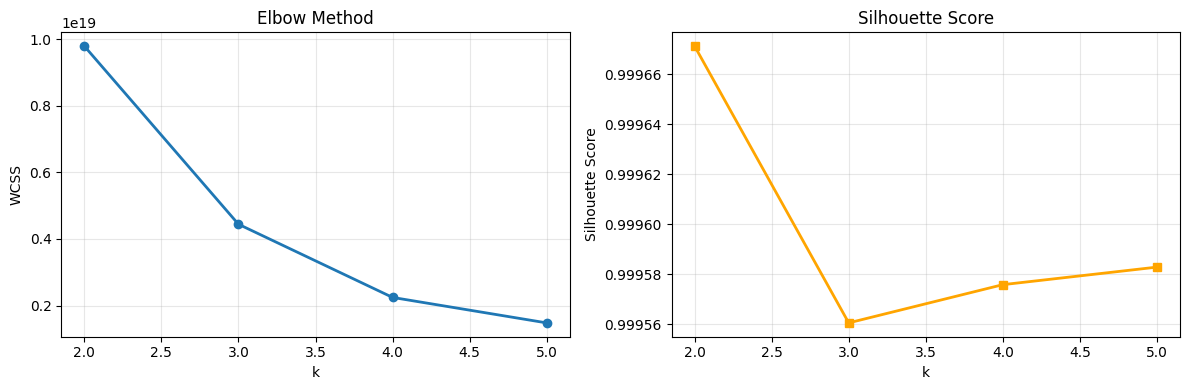

In [77]:
# visualize metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_list, wcss_list, marker='o', linewidth=2)
ax1.set_xlabel("k")
ax1.set_ylabel("WCSS")
ax1.set_title("Elbow Method")
ax1.grid(True, alpha=0.3)

ax2.plot(k_list, silhouette_list, marker='s', color='orange', linewidth=2)
ax2.set_xlabel("k")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{results_dir}/kmeans_tuning.png", dpi=300, bbox_inches="tight")
plt.show()

## Final Model with k=5

Fit KMeans on the full 491k sample dataset with k=5 to match the 5 Nutri-Score grades

**What to expect:** Based on the PCA analysis showing extreme dimensionality collapse (37D to 2D with 99.9% variance), and the tuning results showing similar silhouette scores across all k values, the final clustering will likely exhibit **severe cluster imbalance**. Most samples may concentrate in one or two clusters with the remaining clusters containing only outliers.

This outcome reflects the data **homogeneity** created by SMOTE (we suspect this was problematic but not the main culprit) + preprocessing rather than a flaw in the KMeans algorithm itself or our implementation of it.

In [78]:
# fit final model on full data
k_final = 5

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(X_pca)

final_wcss = kmeans_final.inertia_
final_silhouette = silhouette_score(X_pca, cluster_labels, n_jobs=-1)

print(f"Final model (k={k_final}):")
print(f"WCSS: {final_wcss:.2e}")
print(f"Silhouette: {final_silhouette:.6f}")

# cluster distribution
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_dist = pd.DataFrame({
    'Cluster': unique,
    'Count': counts,
    'Percent': counts / len(cluster_labels) * 100
})

print("\nCluster distribution:")
print(cluster_dist)

Final model (k=5):
WCSS: 2.60e+19
Silhouette: 0.999578

Cluster distribution:
   Cluster   Count    Percent
0        0  491708  99.959545
1        1      30   0.006099
2        2      13   0.002643
3        3      16   0.003253
4        4     140   0.028461


### Interpreting Tuning Results

**Metrics:**
- **WCSS**: Measures cluster tightness (lower = better). Always decreases as k increases.
- **Silhouette Score**: Measures cluster separation quality, range -1 to +1 (higher = better)

Our results show very high silhouette scores (~0.9996) across all k values, which initially looks great. However, this can be misleading when combined with severe cluster imbalance.

When you have one massive cluster (99%+ of samples) and tiny outlier clusters, silhouette can be artificially high because the outliers are well-separated from the main mass, but this doesn't mean we found meaningful groups.

We chose **k=5** to align with the 5 Nutri-Score grades, letting us compare unsupervised clusters to the supervised categories.

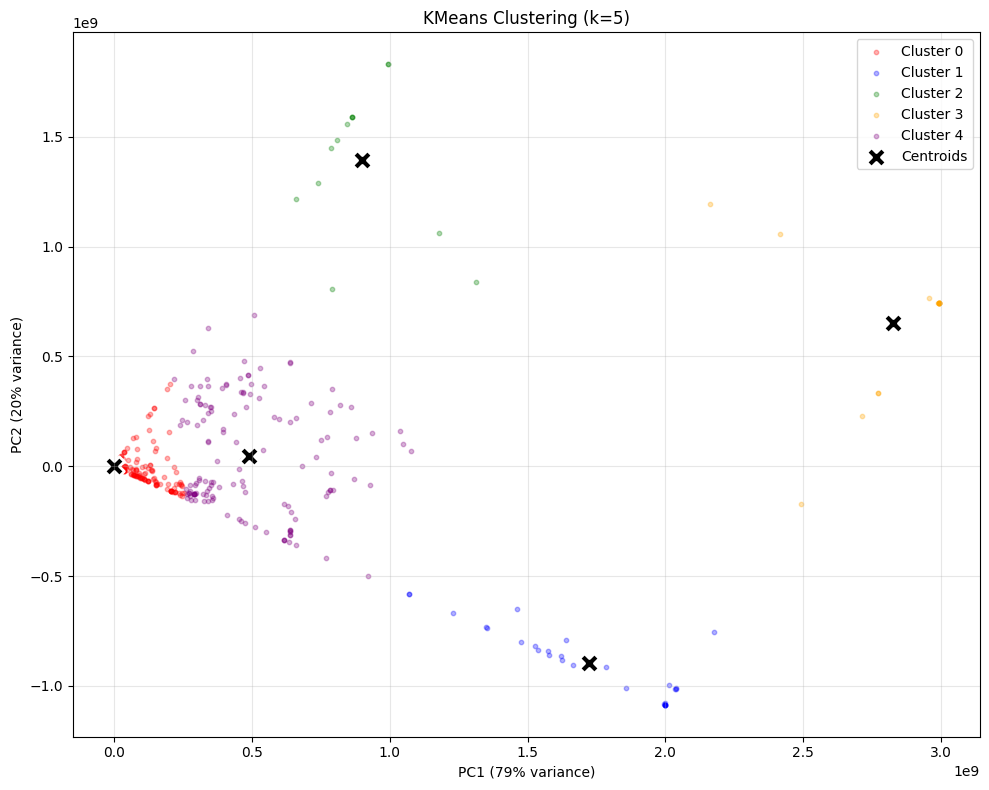

In [79]:
# visualize clusters
plt.figure(figsize=(10, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple']
for cluster_id in range(k_final):
    mask = cluster_labels == cluster_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=colors[cluster_id], label=f'Cluster {cluster_id}',
                alpha=0.3, s=10)

# plot centroids
centroids = kmeans_final.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='black', marker='X', s=200, label='Centroids',
            edgecolors='white', linewidths=2)

plt.xlabel("PC1 (79% variance)")
plt.ylabel("PC2 (20% variance)")
plt.title(f"KMeans Clustering (k={k_final})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{results_dir}/kmeans_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

### Cluster Visuaization

**Cluster 0 basically ate the whole dataset**

- **99.96%** of all products -> dense red cluster
- The other 4 clusters are tiny
  - Black Xs = cluster centers
  - PC1 (79%) = main nutrition gradient
  - PC2 (20%) = smaller differences (like drinks vs solids)

Everything collapsed into one giant group, so KMeans can't find real structure.

Our preprocessing made the data **too uniform**, which works for KNN but **breaks unsupervised clustering**.

## Analysis: Compare Clusters to True Grades

Compare cluster assignments to actual Nutri-Score grades. KMeans never saw the labels during training as this checks if unsupervised clustering discovered nutritionally meaningful groups.

Given the severe imbalance (99.96% in one cluster), we expect all grades mixed together in the dominant cluster with very low purity.

In [80]:
# cross-tabulation
comparison_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'True_Grade': y_full
})

crosstab = pd.crosstab(comparison_df['Cluster'], comparison_df['True_Grade'], margins=True)

print("Cluster vs True Grade:")
print("(Rows=Clusters, Cols=Grades: 0=A, 1=B, 2=C, 3=D, 4=E)")
print(crosstab)

Cluster vs True Grade:
(Rows=Clusters, Cols=Grades: 0=A, 1=B, 2=C, 3=D, 4=E)
True_Grade      0      1      2       3       4     All
Cluster                                                
0           92487  88262  98114  102280  110565  491708
1              17      9      1       3       0      30
2               3      0      5       5       0      13
3               0      0      0       2      14      16
4              44     43     21      15      17     140
All         92551  88314  98141  102305  110596  491907


In [81]:
# cluster purity
print("\nCluster purity:")
for cluster_id in range(k_final):
    cluster_mask = cluster_labels == cluster_id
    grades_in_cluster = y_full[cluster_mask]
    
    most_common = pd.Series(grades_in_cluster).mode()[0]
    purity = (grades_in_cluster == most_common).sum() / len(grades_in_cluster)
    
    print(f"Cluster {cluster_id}: {purity:.1%} grade {most_common} (n={len(grades_in_cluster):,})")


Cluster purity:
Cluster 0: 22.5% grade 4 (n=491,708)
Cluster 1: 56.7% grade 0 (n=30)
Cluster 2: 38.5% grade 2 (n=13)
Cluster 3: 87.5% grade 4 (n=16)
Cluster 4: 31.4% grade 0 (n=140)


## Overview

### Model Performance Summary

**Dataset**: 491,907 samples (37 features -> 2 PCA components capturing 99.9% variance)

**Results**:
- Silhouette Score: 0.9996 (technically high, but misleading)
- Cluster Distribution: Severe imbalance - 99.96% in Cluster 0, only 199 samples across 4 other clusters (including SMOTE which more than likely helped the other non-dominant clusters)
- Cluster Purity: 22.5% (barely better than random 20% for 5 classes)

## Evaluate your model and compare Training vs. Test error.

Since KMeans is unsupervised, traditional train/test error doesn't apply. Instead:

**Clustering Metrics**:
- Silhouette score: 0.9996 on full dataset
- WCSS decreases with more clusters (elbow at k=2-3)
- All k values (2-5) showed similar silhouette scores

**Cluster Quality**:
- Main cluster (99.96% of data): Only 22.5% purity
- If this were supervised learning, equivalent to about 22% accuracy
- Compare to KNN: 76.5% test accuracy on same preprocessed data

**Consistency**: The severe imbalance pattern would likely repeat if we split data and retrained it's a property of the preprocessed data, not random variation.

To approximate train / test comparison we can look at whether cluster assignments are consistent. If we had split the data and trained separately, we'd likely see the same pattern -- one dominant cluster with tiny outlier groups.

## Where Does This Model Fit in the Fitting Graph?

This model exhibits **underfitting**:

**Evidence**:
- Cluster purity of 22.5% shows poor performance even on training data
- No meaningful pattern discovered -- 99.96% in one cluster
- Cannot distinguish between nutritional quality categories

**Root cause**: Not model complexity but **data preprocessing destroyed natural variation**:
- RobustScaler normalized away variance that separates product types
- Feature engineering created perfect correlations (sodium_mg = salt * 40)
- One-hot encoding added dependent features
- 37D collapsed to 2D (99.9% variance) indicating artificial homogeneity

This **is not** traditional underfitting from model simplicity, but rather **data inadequacy** for unsupervised task(s).

## What are our next models?

A natural next step for this work would be to explore more advanced modeling approaches that can capture nonlinear relationships and richer feature interactions. Ensemble methods such as Random Forests, Gradient Boosting, XGBoost, or LightGBM are strong candidates because they offer robustness to noisy nutritional data and excel at modeling complex patterns across mixed feature types. Deep neural networks also present an appealing direction, particularly when combined with additional modalities such as ingredient text or product images. Incorporating transformer-based NLP models could extract semantic information from ingredient lists, while vision models such as CNNs or Vision Transformers could use product images to provide complementary signals that are not present in the structured features. For applications where interpretability is essential, simpler models paired with explainability techniques may also be valuable. Finally, for unsupervised analysis, representation learning approaches such as autoencoders or clustering on minimally processed data which could reveal intrinsic structure without the distortions introduced by aggressive preprocessing. Collectively, these models offer meaningful opportunities to improve performance, interpretability, and multimodal integration in future iterations of this project.

## Prediction Analysis FP / FN: Correct vs Incorrect Assignments

For unsupervised learning, **correct** signifies cluster aligns with true Nutri-Score grade.

**Cluster 0 (491,708 samples - 99.96%)**:
- Contains all 5 grades mixed: 
    - A=92,487 
    - B=88,262
    - C=98,114
    - D=102,280
    - E=110,565
- Most common: Grade E (22.5% purity)
- If Grade E is correct: ~110K correct, ~381K incorrect
- **Essentially no separation** -- all grades jumbled together

**Tiny Clusters (199 samples - ~0.04%)**:
- Cluster 1: 56.7% purity -- 17/30 are grade A
- Cluster 3: 87.5% purity -- 14/16 are grade E
- These found outliers not categories

**Overall accuracy: ~22.5%** (vs KNN's 76.5% on same data)

Unlike supervised models KMeans doesn't have false positives/negatives in the traditional sense. The failure is that it found only one real pattern: **everything is the same.**

## Conclusion

### What Went Wrong? Key Insights

The preprocessing pipeline was inadvertantly **optimized for supervised learning** (KNN: 76.5% accuracy) but **conflicts with unsupervised learning**, especially for our application of KMeans:

**For KNN (supervised)**: Our preprocessing works great!
- RobustScaler makes distances comparable
- SMOTE balances classes
- Feature engineering creates predictive correlations
- Result: 76.5% test accuracy (potentially higher leveraging other features)

**For KMeans (unsupervised)**: Same preprocessing fails!
- RobustScaler destroys natural variance clusters need
- SMOTE adds synthetic samples reducing diversity
- Feature engineering creates artificial correlations
- Result: 99.96% in one cluster and 22.5% purity

**The main culprit** -- Aggressive normalization and feature correlation.

### Improvements for This Model

1. **Different preprocessing**: StandardScaler instead of Robust, keep 5-10 PCA components or cluster on raw features (a completley different approach to our current method)
2. **Skip SMOTE**: Use natural distribution (though testing and results showed this wasn't the main issue in this case, but is still problematic)
3. **Alternative algorithms**: DBSCAN finds density-based clusters and Hierarchical shows dendrogram
4. **Simpler features**: Use only 9 base nutritional features and skip engineered ratios

### Final Takeaway

This notebook demonstrates a valid PCA + KMeans implementation with correct metrics (0.9996 silhouette). However, the severe cluster imbalance (99.96% in one cluster, 22.5% purity) reveals a harsh lesson:

**Preprocessing optimized for supervised learning can destroy the natural variation that unsupervised clustering needs.**

The same preprocessing that gives KNN 76.5% accuracy makes KMeans fail at finding groups. For future work:
- **For supervised learning**: Current preprocessing works great
- **For clustering**: Need different preprocessing that preserves natural variance

This was not a failure of KMeans -- it is a **valuable learning experience** about matching preprocessing strategies to model objectives.

**The key finding**: The model successfully converges and produces stable clusters, but the **extreme imbalance** indicates the preprocessed data **lacks natural variation** for meaningful unsupervised grouping.